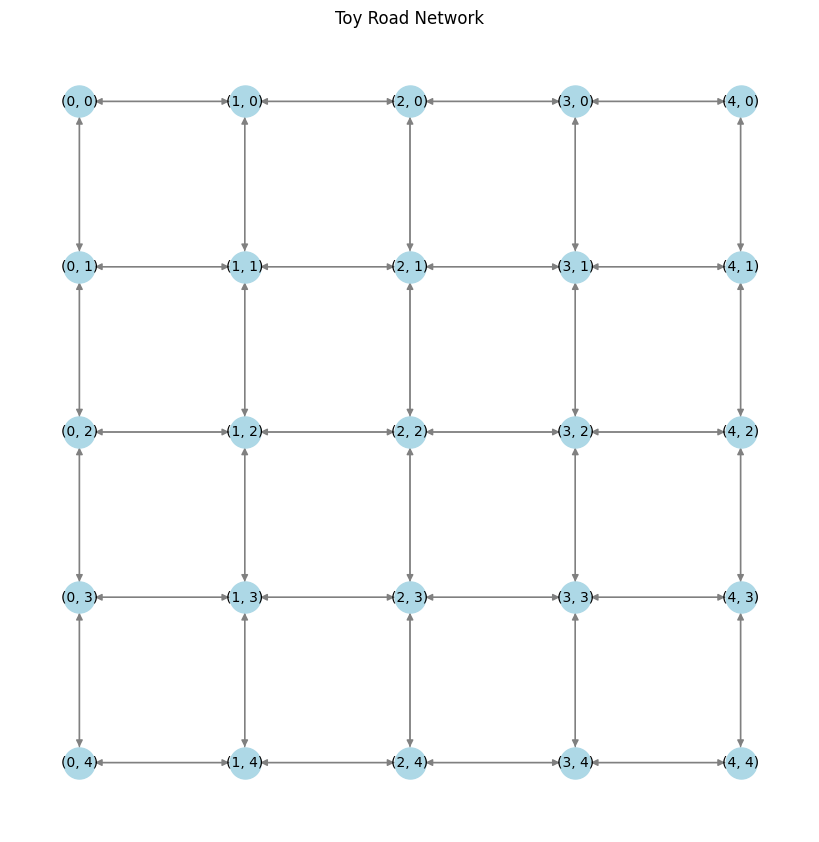

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def generate_road_network(grid_size=(5, 5), seed=42):
    """Generates a toy road network as a grid with some random connections."""
    np.random.seed(seed)
    G = nx.grid_2d_graph(*grid_size)
    
    # Convert to a directed graph (roads with directions)
    DG = nx.DiGraph(G)
    
    # Assign random weights (e.g., road lengths in miles) and AADT values
    for u, v in DG.edges():
        DG[u][v]['length'] = np.random.uniform(0.06, 0.31)  # Road length in miles (converted from meters)
        DG[u][v]['AADT'] = np.random.randint(500, 5000)  # Annual Average Daily Traffic
    
    return DG

def plot_road_network(G):
    """Plots the generated road network."""
    pos = {node: (node[0], -node[1]) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title("Toy Road Network")
    plt.show()

# Jupyter Notebook Execution
road_network = generate_road_network()
plot_road_network(road_network)


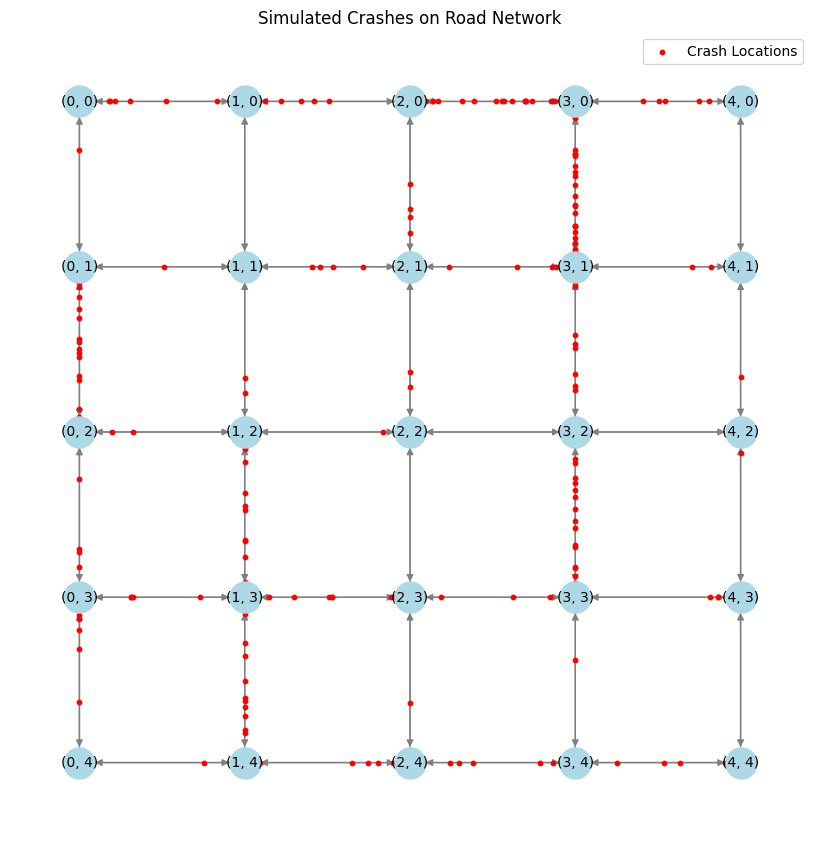

,segment,AADT,length,x_coord,y_coord
0,"((0, 0), (1, 0))",1360,0.153635,0.969910,0.000000
1,"((0, 0), (1, 0))",1360,0.153635,0.832443,0.000000
2,"((0, 0), (1, 0))",1360,0.153635,0.212339,0.000000
3,"((0, 0), (1, 0))",1360,0.153635,0.181825,0.000000
4,"((0, 0), (1, 0))",1360,0.153635,0.183405,0.000000
...,...,...,...,...,...
221,"((4, 3), (4, 2))",4597,0.126695,4.000000,2.126421
222,"((4, 3), (4, 2))",4597,0.126695,4.000000,2.079128
223,"((4, 4), (3, 4))",3974,0.129662,3.631086,4.000000
224,"((4, 4), (3, 4))",3974,0.129662,3.537465,4.000000


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import networkx as nx
import matplotlib.pyplot as plt

def simulate_crash_data(G, alpha=0.5, beta=0.3, dispersion=1.5, seed=42):
    """Simulates crash data using a Negative Binomial model and assigns crash locations along the links."""
    np.random.seed(seed)
    crash_records = []
    
    # Select a specific link to be more dangerous
    dangerous_link = list(G.edges())[np.random.randint(len(G.edges()))]
    
    for u, v, data in G.edges(data=True):
        AADT = data['AADT']
        length = data['length']
        
        # Safety Performance Function (SPF): Expected crashes per segment
        expected_crashes = np.exp(alpha + beta * np.log(AADT)) * length  # Crashes per mile
        
        # Increase crash risk for the selected dangerous link
        if (u, v) == dangerous_link:
            expected_crashes *= 50  # Increase expected crashes for the selected segment
        
        # Negative Binomial random variation
        observed_crashes = stats.nbinom.rvs(n=1/dispersion, p=1/(1 + expected_crashes * dispersion))
        
        # Generate individual crash records with locations along the segment
        for _ in range(observed_crashes):
            crash_position = np.random.uniform(0, 1)  # Random position along the link
            x_coord = u[0] + crash_position * (v[0] - u[0])
            y_coord = u[1] + crash_position * (v[1] - u[1])
            
            crash_records.append({
                'segment': (u, v),
                'AADT': AADT,
                'length': length,
                'x_coord': x_coord,
                'y_coord': y_coord
            })
    
    return pd.DataFrame(crash_records)

def plot_crash_data(G, crash_df):
    """Plots the road network with individual crash locations."""
    pos = {node: (node[0], -node[1]) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.scatter(crash_df['x_coord'], -crash_df['y_coord'], c='red', s=10, label='Crash Locations')
    plt.title("Simulated Crashes on Road Network")
    plt.legend()
    plt.show()

# Jupyter Notebook Execution
road_network = generate_road_network()
crash_data = simulate_crash_data(road_network)
plot_crash_data(road_network, crash_data)

# Display crash data
display(crash_data)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde

def apply_kde_no_autocorrelation(crash_df, bandwidth=0.1):
    """Applies Kernel Density Estimation (KDE) to crash locations without considering autocorrelation."""
    crash_points = crash_df[['x_coord', 'y_coord']].values
    weights = np.ones(len(crash_points))  # Each crash has equal weight
    
    # Perform KDE
    kde = gaussian_kde(crash_points.T, weights=weights, bw_method=bandwidth)
    
    # Create a meshgrid for visualization
    x_min, x_max = crash_points[:, 0].min() - 1, crash_points[:, 0].max() + 1
    y_min, y_max = crash_points[:, 1].min() - 1, crash_points[:, 1].max() + 1
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(grid_coords).reshape(x_grid.shape)
    
    # Plot the KDE heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(density, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='Reds', alpha=0.6)
    plt.colorbar(label='Crash Density')
    plt.scatter(crash_points[:, 0], crash_points[:, 1], c='blue', s=10, alpha=0.5, label='Crash Locations')
    plt.title("Kernel Density Estimation of Crashes (No Autocorrelation)")
    plt.legend()
    plt.show()






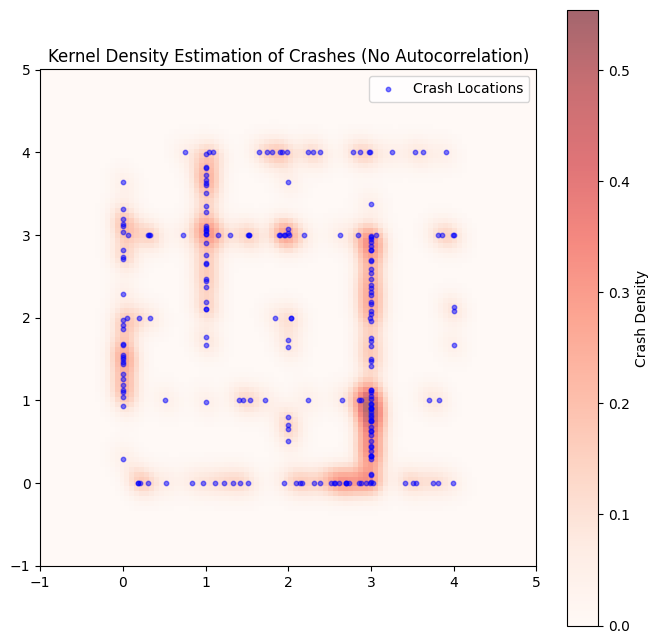

In [4]:
# Jupyter Notebook Execution
apply_kde_no_autocorrelation(crash_data)


In [5]:
def apply_dbscan(crash_df, eps=0.2, min_samples=3):
    """Applies DBSCAN clustering to crash locations."""
    crash_points = crash_df[['x_coord', 'y_coord']].values
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(crash_points)
    
    # Plot results
    plt.figure(figsize=(8, 8))
    unique_labels = set(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'black'  # Noise points
        cluster_points = crash_points[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], s=20, label=f'Cluster {label}')
    
    plt.title("DBSCAN Clustering of Crash Locations")
    plt.legend()
    plt.show()

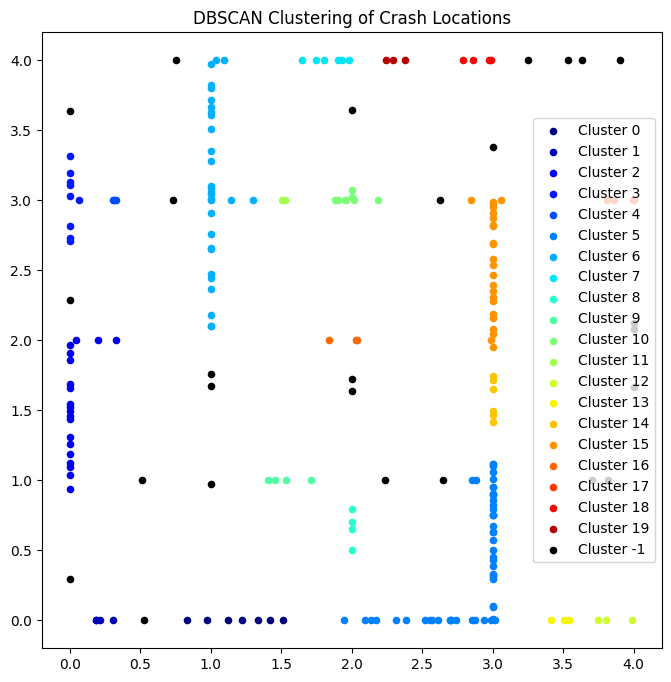

In [6]:
apply_dbscan(crash_data)